In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

## State variables

$$ \mathit{\mathbf{x}}  = [x, y, z] $$

where z = 0 in 2D scene

## Process Model & Q 

In [2]:
def skew(vector):
    """
    this function returns a numpy array with the skew symmetric cross product matrix for vector.
    the skew symmetric cross product matrix is defined such that
    np.cross(a, b) = np.dot(skew(a), b)

    :param vector: An array like vector to create the skew symmetric cross product matrix for
    :return: A numpy array of the skew symmetric cross product vector
    """

    return np.array(
        [
            [0, -vector[2], vector[1]],
            [vector[2], 0, -vector[0]],
            [-vector[1], vector[0], 0],
        ]
    )

In [3]:
def f_contact(x, dt, u):
    A = np.identity(3)
    B = -dt * np.append(np.identity(3), skew(x), axis=1)    # -skew(p) ???
    prior_ = A @ x - B @ u # DYX: it should be plus, but here there's a coordinate translation needed to be done !!!
                            # -u is the velocity of base under fixed-world frame, if so, we should fix this and unify the frame
    return prior_

In [4]:
# Process Noise
Q = np.array([[.001, 0, 0], [0, .001, 0], [0, 0, .00001]])

## Measurement Model & R

In [5]:
def polyfit2d(x, y, z, kx=5, ky=5, order=None):
    """
    Two dimensional polynomial fitting by least squares.
    Fits the functional form f(x,y) = z.

    Notes
    -----
    Resultant fit can be plotted with:
    np.polynomial.polynomial.polygrid2d(x, y, soln.reshape((kx+1, ky+1)))

    Parameters
    ----------
    x, y: array-like, 1d
        x and y coordinates.
    z: np.ndarray, 2d
        Surface to fit.
    kx, ky: int, default is 3
        Polynomial order in x and y, respectively.
    order: int or None, default is None
        If None, all coefficients up to maxiumum kx, ky, ie. up to and including x^kx*y^ky, are considered.
        If int, coefficients up to a maximum of kx+ky <= order are considered.

    Returns
    -------
    Return paramters from np.linalg.lstsq.

    soln: np.ndarray
        Array of polynomial coefficients.
    residuals: np.ndarray
    rank: int
    s: np.ndarray

    """

    # grid coords
    x, y = np.meshgrid(x, y)
    # coefficient array, up to x^kx, y^ky
    coeffs = np.ones((kx + 1, ky + 1))

    # solve array
    a = np.zeros((coeffs.size, x.size))

    # for each coefficient produce array x^i, y^j
    for index, (i, j) in enumerate(np.ndindex(coeffs.shape)):
        # do not include powers greater than order
        if order is not None and i + j > order:
            arr = np.zeros_like(x)
        else:
            arr = coeffs[i, j] * x**i * y**j
        a[index] = arr.ravel()

    # do leastsq fitting and return leastsq result
    print(a.T.shape, np.ravel(z).shape)
    return np.linalg.lstsq(a.T, np.ravel(z), rcond=None)

In [6]:
import pandas as pd

dataframe = pd.read_excel("data/FullRangeData.xlsx", sheet_name="Formated_MannulyFixed")
z = np.array(dataframe)[:, 2]

x = np.linspace(10, 90, 17)
y = np.linspace(115, 160, 10)

coeff, r, rank, s = polyfit2d(x, y, z)

(170, 36) (170,)


In [7]:
from sklearn.metrics import r2_score

fitted_surf = np.polynomial.polynomial.polygrid2d(x, y, coeff.reshape((6, 6)))

rms = np.sqrt(np.mean((z.reshape(10, 17).T - fitted_surf) ** 2))
print("RMS residual =", rms)
score = r2_score(z.reshape(10, 17).T, fitted_surf)
print("R-squared value =", score)

RMS residual = 0.1940122848922954
R-squared value = 0.9940472000309433


In [8]:
def h_contact(x):
    return np.polynomial.polynomial.polygrid2d(x[0], x[1], coeff.reshape((6, 6)))

In [9]:
# Measurement Noise
R = np.array([[rms**2]])

## Data Preprocess

In [10]:
# Data format : 
#           timestamp，
#           magnetic_x, magnetic_y, magnetic_z, 
#           lv_x, lv_y, lv_z, av_x, av_y. av_z

trajectory_df = pd.read_csv("data/D_plane_1_3/trajectory.csv")

In [11]:
# delta time : second s

from datetime import datetime

dt_frame = np.array(trajectory_df)[:, 0]

dt = [0]
for i in range(1, dt_frame.shape[0]):
    tr = datetime.fromtimestamp(dt_frame[i])
    tf = datetime.fromtimestamp(dt_frame[i-1])
    dt.append((tr-tf).total_seconds())
dt = np.array(dt)

In [12]:
# linear- and angular-veolocity : mm/s & rad/s 

# be careful of coordinate frame translation !!!
linear_vel = np.array([np.array(trajectory_df)[:, 5], -np.array(trajectory_df)[:, 6], np.array(trajectory_df)[:, 4]]) * 1e3
angular_vel = np.array([np.array(trajectory_df)[:, 7], np.array(trajectory_df)[:, 8], np.array(trajectory_df)[:, 9]])

us = np.append(linear_vel, angular_vel, axis=0).T

In [13]:
# Measurements Update : magnetic_y
zs = [np.array([np.array(trajectory_df)[i, 2]]) for i in range(trajectory_df.shape[0])]

## UKF with Fading Memory

In [14]:
# Initial estimate

x_initial = np.array([50, 115, 0])

In [15]:
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints

sigmas = MerweScaledSigmaPoints(3, alpha=.1, beta=2., kappa=0.)
ukf = UKF(dim_x=3, dim_z=1, fx=f_contact,
          hx=h_contact, dt=None, points=sigmas)

ukf.x = x_initial
ukf.R = R
ukf.Q = Q

# Introduce adaptive fading memory filter to compensate the error from dynamic contact 
ukf.alpha = 1.003

In [16]:
ukf

UnscentedKalmanFilter object
x = [ 50 115   0]
P = [[1. 0. 0.]
     [0. 1. 0.]
     [0. 0. 1.]]
x_prior = [0. 0. 0.]
P_prior = [[1. 0. 0.]
           [0. 1. 0.]
           [0. 0. 1.]]
Q = [[1.e-03 0.e+00 0.e+00]
     [0.e+00 1.e-03 0.e+00]
     [0.e+00 0.e+00 1.e-05]]
R = [[0.03764077]]
S = [[0.]]
K = [[0. 0. 0.]].T
y = [0.]
log-likelihood = -708.3964185322641
likelihood = 2.2250738585072014e-308
mahalanobis = 0.0
sigmas_f = [[0. 0. 0.]
            [0. 0. 0.]
            [0. 0. 0.]
            [0. 0. 0.]
            [0. 0. 0.]
            [0. 0. 0.]
            [0. 0. 0.]]
h = [[0. 0. 0. 0. 0. 0. 0.]].T
Wm = [-99.          16.66666667  16.66666667  16.66666667  16.66666667
       16.66666667  16.66666667]
Wc = [-96.01        16.66666667  16.66666667  16.66666667  16.66666667
       16.66666667  16.66666667]
residual_x = <ufunc 'subtract'>
residual_z = <ufunc 'subtract'>
msqrt = <function cholesky at 0x000001FEE51F44C0>
hx = <function h_contact at 0x000001FEDEF074C0>
fx = <function f_co

In [17]:
uxs = []
for _ in range(len(zs)):
    ukf.predict(u=us[_], dt=dt[_])
    ukf.update(zs[_])
    uxs.append(ukf.x.copy())
uxs = np.array(uxs)

[[ 5.50750906e+01  1.14925070e+02  2.40090907e-16]
 [ 5.91297673e+01  1.16080172e+02  5.57652331e-16]
 [ 6.24249452e+01  1.17984420e+02 -2.47295716e-12]
 ...
 [ 9.24879649e+01  1.32367528e+02 -4.32515150e-10]
 [ 9.24989443e+01  1.32307355e+02 -4.32514546e-10]
 [ 9.24220013e+01  1.32433905e+02 -4.32514532e-10]]


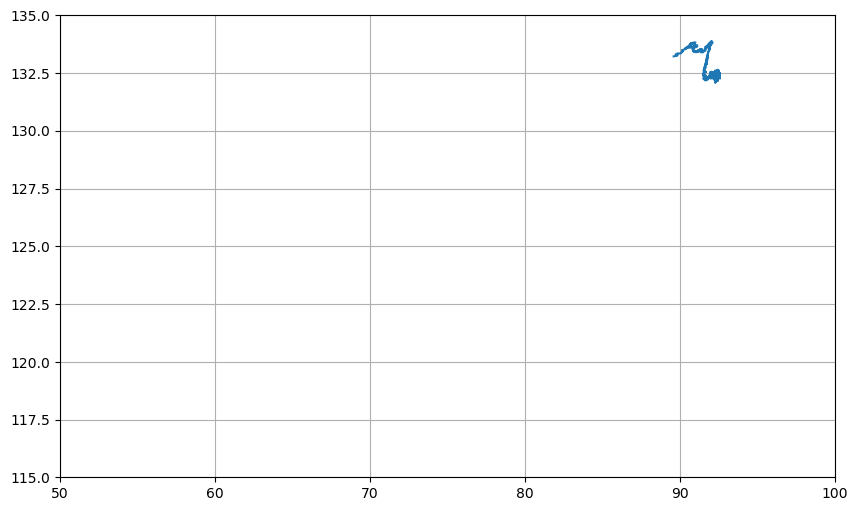

In [18]:
print(uxs)

plt.figure(figsize=(10, 6))
plt.grid()
plt.ylim([115, 135])
plt.xlim([50, 100])
plt.plot(uxs[300:, 0], uxs[300:, 1], label='Estimated Trajectory')

#### Dynamic contact results:

In [19]:
# set the first base frame position as the origin of fixed world frame

uxs_ = []
displacement = np.array([0. ,0. ,0.]) # overall position displacement from first iteration

for _ in range(uxs.shape[0]):
    displacement += np.dot(us[_][:3], dt[_])
    temp = uxs[_] + displacement
    uxs_.append(temp)
uxs_ = np.array(uxs_)

[[ 5.50750906e+01  1.14925070e+02  2.40090907e-16]
 [ 5.92544521e+01  1.16080172e+02  5.57652331e-16]
 [ 6.26708060e+01  1.17984420e+02 -4.94597895e-12]
 ...
 [ 2.00700831e+02  1.32367528e+02 -8.64920206e-10]
 [ 2.00733628e+02  1.32307355e+02 -8.64919602e-10]
 [ 2.00779115e+02  1.32433905e+02 -8.64919588e-10]]


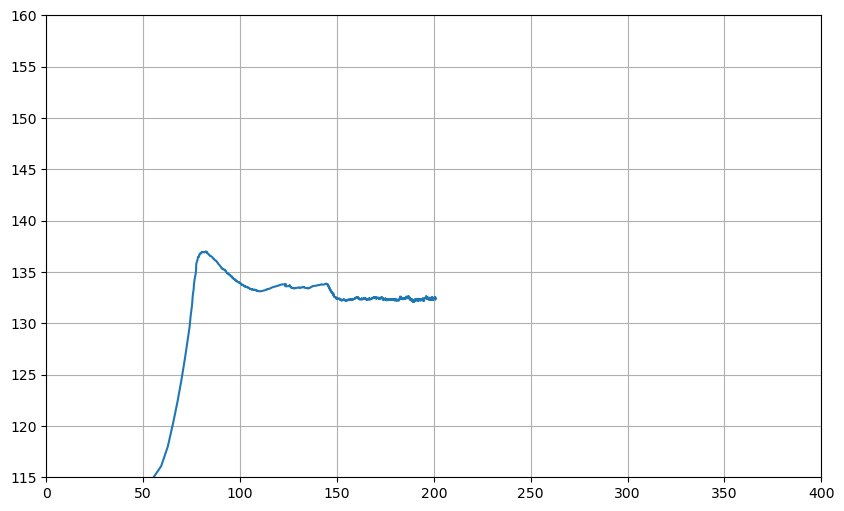

In [22]:
print(uxs_)

plt.figure(figsize=(10, 6))
plt.grid()
plt.ylim([115, 160])
plt.xlim([0, 400])
plt.plot(uxs_[:, 0], uxs_[:, 1], label='Estimated Trajectory')